In [70]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [71]:
data = pd.read_csv("/Users/farhat/Documents/Project/ProcessedData/fullData.csv")

# Training data and Label data split
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

#Train test split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, Y,                 # Features and labels
                                                    test_size=0.2,        # 20% for testing
                                                    random_state=42,      # Ensures reproducibility
                                                    stratify=Y            # (Optional) maintains label proportions
)

In [72]:
# Storing the test labels in different directory
# Combine X_test and y_test into one DataFrame

combined = X_test.copy()
combined['label'] = y_test.values  # Make sure index alignment is preserved

# Create output folder if not exists
output_dir = "/Users/farhat/Documents/Project/ProcessedData/LabelDirectory"
os.makedirs(output_dir, exist_ok=True)

# Group by patient_id and save each group as a separate .psv file
for patient_id, group in combined.groupby('Patient_Id'):
    # Only save the label column (or keep other columns if needed)
    patient_labels = group[['label']].rename(columns={'label': 'SepsisLabel'})
    
    # Build file path
    filename = f"{patient_id}.psv"
    filepath = os.path.join(output_dir, filename)
    
    # Save to .psv (pipe-separated)
    patient_labels.to_csv(filepath, sep='|', index=False)


In [73]:
# Hyper paramters selection and tunning using grid search CV
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 12, 15],
    'learning_rate': [0.05, 0.1, 0.12, 0.15],
    'n_estimators': [ 200, 400, 600, 650, 700]
}

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train.iloc[:,1:], y_train)

# Storing the result in a dataframe

results = pd.DataFrame(grid_search.cv_results_)
results['cv'] = grid_search.cv
df = pd.read_csv('Results.csv')
df = pd.concat([df,results], ignore_index=True)
df.to_csv('Results.csv')


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

In [74]:
best_param = grid_search.best_params_
testing_best_param = pd.DataFrame([best_param])
testing_best_param['cv']=grid_search.cv
testing_best_param

,learning_rate,max_depth,n_estimators,cv
0,0.12,15,650,3


In [75]:
# Best model estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test.iloc[:,1:])

In [76]:
# Accuracy Score
y_pred = y_pred[:,1] # Probability of 1
y_pred_binary = (y_pred >=0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
testing_best_param['accuracy']=accuracy
print(f"Tuned Model Accuracy: {accuracy:.4f}")

Tuned Model Accuracy: 0.9992


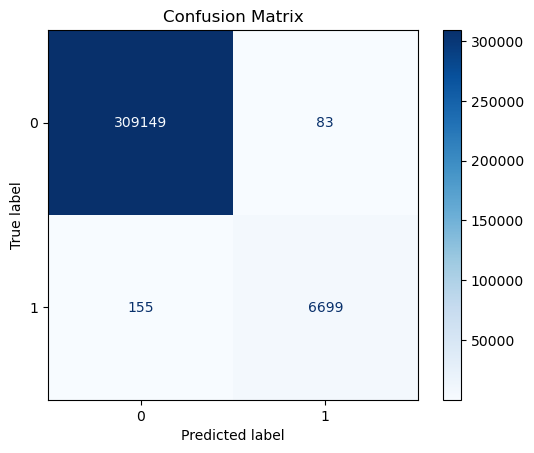

In [77]:
cm =confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # You can change the color map
testing_best_param['TN']=cm[0,0]
testing_best_param['FP']=cm[0,1]
testing_best_param['FN']=cm[1,0]
testing_best_param['TP']=cm[1,1]
plt.title("Confusion Matrix")
plt.show()


In [78]:
# Add predicted probabilities
combined['PredictedProbability'] = y_pred

# Add predicted labels based on threshold 0.5
combined['PredictedLabel'] = (combined['PredictedProbability'] >= 0.5).astype(int)


In [79]:
# Ensure patient_id is present
if 'Patient_Id' not in combined.columns:
    raise ValueError("The column 'patient_id' must be present in X_test.")

# Create output folder
output_dir = "/Users/farhat/Documents/Project/ProcessedData/PredictionDirectory"
os.makedirs(output_dir, exist_ok=True)

# Group by patient_id and write predictions
for patient_id, group in combined.groupby('Patient_Id'):
    # Keep only necessary columns
    patient_predictions = group[['PredictedLabel', 'PredictedProbability']]

    # Create file path
    filename = f"{patient_id}.psv"
    filepath = os.path.join(output_dir, filename)

    # Save to .psv
    patient_predictions.to_csv(filepath, sep='|', index=False)


In [80]:
# Getting utility score proposed for the competition
#!/usr/bin/env python

# This file contains functions for evaluating algorithms for the 2019 PhysioNet/
# CinC Challenge. You can run it as follows:
#
#   python evaluate_sepsis_score.py labels predictions scores.psv
#
# where 'labels' is a directory containing files with labels, 'predictions' is a
# directory containing files with predictions, and 'scores.psv' (optional) is a
# collection of scores for the predictions.

################################################################################

# The evaluate_scores function computes a normalized utility score for a cohort
# of patients along with several traditional scoring metrics.
#
# Inputs:
#   'label_directory' is a directory of pipe-delimited text files containing a
#   binary vector of labels for whether a patient is not septic (0) or septic
#   (1) for each time interval.
#
#   'prediction_directory' is a directory of pipea-delimited text files, where
#   the first column of the file gives the predicted probability that the
#   patient is septic at each time, and the second column of the file is a
#   binarized version of this vector. Note that there must be a prediction for
#   every label.
#
# Outputs:
#   'auroc' is the area under the receiver operating characteristic curve
#   (AUROC).
#
#   'auprc' is the area under the precision recall curve (AUPRC).
#
#   'accuracy' is accuracy.
#
#   'f_measure' is F-measure.
#
#   'normalized_observed_utility' is a normalized utility-based measure that we
#   created for the Challenge. This score is normalized so that a perfect score
#   is 1 and no positive predictions is 0.
#
# Example:
#   Omitted due to length. See the below examples.

label_directory = "/Users/farhat/Documents/Project/ProcessedData/LabelDirectory"
prediction_directory = "/Users/farhat/Documents/Project/ProcessedData/PredictionDirectory"

import numpy as np, os, os.path, sys, warnings

def evaluate_sepsis_score(label_directory, prediction_directory):
    # Set parameters.
    label_header       = 'SepsisLabel'
    prediction_header  = 'PredictedLabel'
    probability_header = 'PredictedProbability'

    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0

    # Find label and prediction files.
    label_files = []
    for f in os.listdir(label_directory):
        g = os.path.join(label_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('psv'):
            label_files.append(g)
    label_files = sorted(label_files)

    prediction_files = []
    for f in os.listdir(prediction_directory):
        g = os.path.join(prediction_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('psv'):
            prediction_files.append(g)
    prediction_files = sorted(prediction_files)

    if len(label_files) != len(prediction_files):
        raise Exception('Numbers of label and prediction files must be the same.')

    # Load labels and predictions.
    num_files            = len(label_files)
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    for k in range(num_files):
        labels        = load_column(label_files[k], label_header, '|')
        predictions   = load_column(prediction_files[k], prediction_header, '|')
        probabilities = load_column(prediction_files[k], probability_header, '|')

        # Check labels and predictions for errors.
        if not (len(labels) == len(predictions) and len(predictions) == len(probabilities)):
            raise Exception('Numbers of labels and predictions for a file must be the same.')

        num_rows = len(labels)

        for i in range(num_rows):
            if labels[i] not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

            if predictions[i] not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if not 0 <= probabilities[i] <= 1:
                warnings.warn('Probabilities do not satisfy 0 <= probability <= 1.')

        if 0 < np.sum(predictions) < num_rows:
            min_probability_positive = np.min(probabilities[predictions == 1])
            max_probability_negative = np.max(probabilities[predictions == 0])

            if min_probability_positive <= max_probability_negative:
                warnings.warn('Predictions are inconsistent with probabilities, i.e., a positive prediction has a lower (or equal) probability than a negative prediction.')

        # Record labels and predictions.
        cohort_labels.append(labels)
        cohort_predictions.append(predictions)
        cohort_probabilities.append(probabilities)

    # Compute AUC, accuracy, and F-measure.
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)

    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    for k in range(num_files):
        labels = cohort_labels[k]
        num_rows          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_rows)
        worst_predictions    = np.zeros(num_rows)
        inaction_predictions = np.zeros(num_rows)

        if np.any(labels):
            t_sepsis = np.argmax(labels) - dt_optimal
            best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, num_rows)] = 1
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)

    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

# The load_column function loads a column from a table.
#
# Inputs:
#   'filename' is a string containing a filename.
#
#   'header' is a string containing a header.
#
# Outputs:
#   'column' is a vector containing a column from the file with the given
#   header.
#
# Example:
#   Omitted.

def load_column(filename, header, delimiter):
    column = []
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            arrs = l.strip().split(delimiter)
            if i == 0:
                try:
                    j = arrs.index(header)
                except:
                    raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
            else:
                if len(arrs[j]):
                    column.append(float(arrs[j]))
    return np.array(column)

# The compute_auc function computes AUROC and AUPRC as well as other summary
# statistics (TP, FP, FN, TN, TPR, TNR, PPV, NPV, etc.) that can be exposed
# from this function.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a probability vector, where predictions[i] gives the
#   predicted probability that the patient is septic at time i.  Note that there
#   must be a prediction for every label, i.e, len(labels) ==
#   len(predictions).
#
# Outputs:
#   'auroc' is a scalar that gives the AUROC of the algorithm using its
#   predicted probabilities, where specificity is interpolated for intermediate
#   sensitivity values.
#
#   'auprc' is a scalar that gives the AUPRC of the algorithm using its
#   predicted probabilities, where precision is a piecewise constant function of
#   recall.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0.3, 0.4, 0.6, 0.7, 0.8, 0.8]
#   In [3]: auroc, auprc = compute_auc(labels, predictions)
#   In [4]: auroc
#   Out[4]: 1.0
#   In [5]: auprc
#   Out[5]: 1.0

def compute_auc(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not 0 <= prediction <= 1:
                warnings.warn('Predictions do not satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.insert(thresholds, 0, 1)
    if thresholds[-1] == 0:
        thresholds = thresholds[:-1]

    n = len(labels)
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort the predicted probabilities from largest to
    # smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels)
            tn[j] = n - fn[j]
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest predicted probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function with TPR /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant with TPR / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr[j + 1] - tpr[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the predictions using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the predictions using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    n = len(labels)
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif not labels[i] and predictions[i]:
            fp += 1
        elif labels[i] and not predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   algorithm using its binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 3.388888888888889

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

        if dt_early >= dt_optimal:
            raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

        if dt_optimal >= dt_late:
            raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = np.argmax(labels) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define slopes and intercept points for utility functions of the form
    # u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

if __name__ == '__main__':
    auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)

    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(auroc, auprc, accuracy, f_measure, utility)
    if len(sys.argv) > 3:
        with open(sys.argv[3], 'w') as f:
            f.write(output_string)
    else:
        print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility
0.999965191870302|0.9984890373373332|0.9992470403624331|0.9825462012320328|0.2928782704228993


In [81]:
auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
testing_best_param[['auroc','auprc', 'accuracy', 'f_measure', 'utility']] = [auroc, auprc, accuracy, f_measure, utility]
testing_results = pd.read_csv('testing_best_param.csv')
testing_best_param = pd.concat([testing_results,testing_best_param])
testing_best_param.to_csv('testing_best_param.csv')

Exception ignored in: <function ResourceTracker.__del__ at 0x10536dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104769bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102e6dbc0>
Traceback (most recent call last